# Proyecto 1 — Analítica de Textos Etapa 1

### Integrantes:
1. Juan Garcia - Líder de proyecto, datos y analitica




In [2]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 47.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# Puedes comentar lo que ya tengas instalado
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# =============================== IMPORTS COMUNES ===================================
import os, re, unicodedata, shutil, zipfile
from datetime import datetime
from typing import Optional, List, Tuple, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Colab (subir/descargar archivos)
try:
    from google.colab import files
    IN_COLAB = True
except Exception:
    files = None
    IN_COLAB = False

# NLP / utilidades
import es_core_news_sm
from wordcloud import WordCloud
from nltk.corpus import stopwords

# ML comunes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.cluster import KMeans
from joblib import dump  # <- persistencia con joblib

# Embeddings (opcional)
import torch
ENABLE_EMBEDDINGS = True
EMB_MODEL = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
EMB_MAX_DOCS = 3000
EMB_MAX_LEN = 256

# =============================== CONFIG GLOBAL =====================================
TRAIN_FILE = "Datos_proyecto.xlsx"
TEST_FILE  = "Datos de prueba_proyecto.xlsx"
LOG_FPATH = "log_ejecucion.txt"
NLP_ES = es_core_news_sm.load(disable=["ner", "parser"])

# -------------------------------------- Utils --------------------------------------
def log(msg: str):
    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    with open(LOG_FPATH, "a", encoding="utf-8") as f:
        f.write(f"[{ts}] {msg}\n")
    print(msg)

def separador(titulo: str):
    print("\n" + "#" * 80)
    print(titulo)
    print("#" * 80 + "\n")
    log(titulo)

def download_file_if_colab(path: str):
    """Descarga automática en Colab (silenciosa si no aplica)."""
    if IN_COLAB and files is not None and os.path.exists(path):
        try:
            files.download(path)
        except Exception as e:
            print(f"[WARN] No se pudo descargar {path}: {e}")

def ensure_expected_file(expected_name: str, descripcion: str) -> Optional[str]:
    if os.path.exists(expected_name):
        print(f"[OK] Encontrado: {expected_name}")
        return expected_name
    print(f"[NECESARIO] Falta el archivo requerido: '{expected_name}' → {descripcion}")
    if IN_COLAB and files is not None:
        print(f"[ACCION] Por favor, sube ahora el archivo EXACTO llamado '{expected_name}'.")
        subidos = files.upload()
        if isinstance(subidos, dict) and any(k == expected_name for k in subidos.keys()):
            print(f"[OK] Subido: {expected_name}")
            return expected_name
        if isinstance(subidos, dict) and len(subidos) == 1:
            alt = list(subidos.keys())[0]
            print(f"[ADVERTENCIA] Se esperaba '{expected_name}', se usará '{alt}' (verifica que corresponda).")
            return alt
    ruta = input(f"Ingrese la ruta al archivo '{expected_name}' (ENTER para cancelar): ").strip()
    if ruta and os.path.exists(ruta):
        print(f"[OK] Usando: {ruta}")
        return ruta
    print(f"[FALTA] No se obtuvo '{expected_name}'.")
    return None

def read_excel_biggest_sheet(path:str)->pd.DataFrame:
    xls = pd.ExcelFile(path)
    print(f"[INFO] Hojas encontradas: {xls.sheet_names}")
    best_sheet, best_len = None, -1
    for sh in xls.sheet_names:
        tmp = pd.read_excel(xls, sh)
        if len(tmp) > best_len:
            best_len, best_sheet = len(tmp), sh
    print(f"[INFO] Hoja seleccionada: '{best_sheet}' ({best_len} filas)")
    return pd.read_excel(xls, best_sheet)

def _avg_len(s: pd.Series)->float:
    return s.dropna().astype(str).map(len).mean() if len(s) else 0.0

def normalize_text(text: str)->str:
    if not isinstance(text, str):
        text = str(text) if text is not None else ""
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"\S+@\S+\.\S+", " ", text)
    text = re.sub(r"@[A-Za-z0-9_]+", " ", text)
    text = re.sub(r"#[A-Za-z0-9_]+", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    text = re.sub(r"[^\w\s]", " ", text, flags=re.UNICODE)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess_series(texts: pd.Series, extra_stopwords: Optional[List[str]]=None)->Tuple[pd.Series, List[List[str]]]:
    base = set(stopwords.words("spanish"))
    base = {w for w in base if w not in {"no","nunca","jamas","nadie","ninguno"}}
    base.update({"si","asi","tampoco","tambien","ser","estar","haber"})
    if extra_stopwords:
        base.update([w.strip().lower() for w in extra_stopwords if w.strip()])
    cleaned = texts.fillna("").astype(str).map(normalize_text)
    tokens_list: List[List[str]] = []
    for t in cleaned:
        doc = NLP_ES(t)
        toks = [tok.lemma_.strip() for tok in doc if tok.is_alpha]
        toks = [w for w in toks if w and w not in base and len(w) > 2]
        tokens_list.append(toks)
    cleaned_joined = pd.Series([" ".join(toks) for toks in tokens_list], index=texts.index)
    return cleaned_joined, tokens_list

from collections import Counter
def most_common_terms(tokens_list: List[List[str]], topn: int=25)->List[Tuple[str,int]]:
    counter = Counter()
    for toks in tokens_list:
        counter.update(toks)
    return counter.most_common(topn)

def most_common_bigrams(tokens_list: List[List[str]], topn: int=25)->List[Tuple[str,int]]:
    counter = Counter()
    for toks in tokens_list:
        for i in range(len(toks)-1):
            counter[f"{toks[i]} {toks[i+1]}"] += 1
    return counter.most_common(topn)


In [11]:
print("=" * 80)
print("PROYECTO 1 - Analítica de Textos")
print("Se requieren 'Datos_proyecto.xlsx' y 'Datos de prueba_proyecto.xlsx' cuando corresponda.")
print("=" * 80)


PROYECTO 1 - Analítica de Textos
Se requieren 'Datos_proyecto.xlsx' y 'Datos de prueba_proyecto.xlsx' cuando corresponda.


## I) Carga y revisión + Perfilamiento de datos



################################################################################
SECCIÓN I. Carga de datos (TRAIN) y revisión inicial
################################################################################

SECCIÓN I. Carga de datos (TRAIN) y revisión inicial
[OK] Encontrado: Datos_proyecto.xlsx
[INFO] Hojas encontradas: ['Sheet1']
[INFO] Hoja seleccionada: 'Sheet1' (2424 filas)
[INFO] Forma del DataFrame: (2424, 2)
Sugerencia columna de TEXTO: textos
Sugerencia columna de ETIQUETA: labels

################################################################################
SECCIÓN I.A. Perfilamiento y calidad de datos
################################################################################

SECCIÓN I.A. Perfilamiento y calidad de datos


,columna,tipo,nulos,%_nulos,unicos,ejemplo
0,textos,object,0,0.0,2424,"""Aprendizaje"" y ""educación"" se consideran sinó..."
1,labels,int64,0,0.0,3,4


,filas,columnas,duplicados,%_duplicados
0,2424,2,0,0.0


,min,p25,p50,p75,max,media
0,303,513.0,647.0,809.25,1492,683.223185


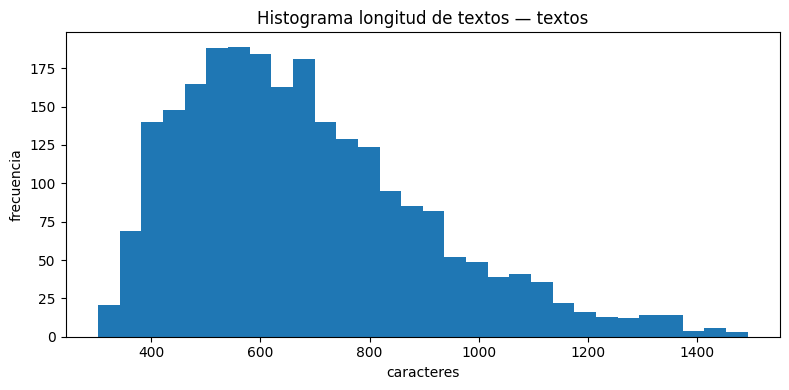

,clase,conteo,%
0,4,1025,42.285479
1,3,894,36.881188
2,1,505,20.833333


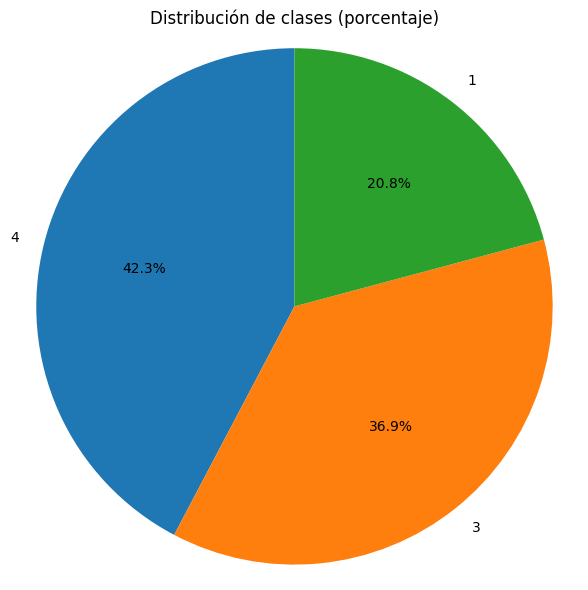

• No se detectaron problemas evidentes de calidad que requieran acción inmediata.


In [12]:
separador("SECCIÓN I. Carga de datos (TRAIN) y revisión inicial")
train_path = ensure_expected_file(TRAIN_FILE, "Archivo PRINCIPAL de entrenamiento (textos + etiqueta).")
if not train_path:
    raise SystemExit(f"[FATAL] No se proporcionó '{TRAIN_FILE}'.")

df = read_excel_biggest_sheet(train_path)
log(f"[INFO] Forma del DataFrame: {df.shape}")

# Sugerencia de columnas
obj_cols = [c for c in df.columns if df[c].dtype == "object" or pd.api.types.is_string_dtype(df[c])]
col_texto_sug = max(obj_cols, key=lambda c: _avg_len(df[c])) if obj_cols else None

candidatas = [(c, df[c].nunique(dropna=True)) for c in df.columns]
candidatas = [(c, n) for c, n in candidatas if 2 <= n <= 50]
candidatas.sort(key=lambda x: x[1])
col_label_sug = candidatas[0][0] if candidatas else None

print(f"Sugerencia columna de TEXTO: {col_texto_sug}")
print(f"Sugerencia columna de ETIQUETA: {col_label_sug}")

# Selección automática
col_texto = col_texto_sug
col_label = col_label_sug
if col_texto not in df.columns:
    raise SystemExit(f"[FATAL] La columna de texto '{col_texto}' no existe.")
if col_label and col_label not in df.columns:
    print("[ADVERTENCIA] Columna de etiqueta inválida. Se continúa sin etiqueta.")
    col_label = None

# --- PERFILAMIENTO explícito ---
separador("SECCIÓN I.A. Perfilamiento y calidad de datos")

perfil_cols = pd.DataFrame({
    "columna": df.columns,
    "tipo": [str(df[c].dtype) for c in df.columns],
    "nulos": [int(df[c].isna().sum()) for c in df.columns],
    "%_nulos": [float(df[c].isna().mean()*100) for c in df.columns],
    "unicos": [int(df[c].nunique(dropna=True)) for c in df.columns],
    "ejemplo": [str(next((v for v in df[c].dropna().head(1).tolist()), ""))[:80] for c in df.columns],
})
perfil_cols.to_csv("perfil_columnas.csv", index=False, encoding="utf-8")
display(perfil_cols.head(12))

duplicados = int(df.duplicated().sum())
resumen_calidad = pd.DataFrame([{
    "filas": int(len(df)), "columnas": int(len(df.columns)),
    "duplicados": duplicados, "%_duplicados": float(duplicados/len(df)*100 if len(df) else 0.0),
}])
resumen_calidad.to_csv("resumen_calidad.csv", index=False, encoding="utf-8")
display(resumen_calidad)

# Longitud de textos (sobre columna original sugerida)
if col_texto is not None:
    lens = df[col_texto].fillna("").astype(str).str.len()
    long_resumen = pd.DataFrame([{
        "min": int(lens.min()) if len(lens) else 0,
        "p25": float(lens.quantile(0.25)) if len(lens) else 0.0,
        "p50": float(lens.quantile(0.50)) if len(lens) else 0.0,
        "p75": float(lens.quantile(0.75)) if len(lens) else 0.0,
        "max": int(lens.max()) if len(lens) else 0,
        "media": float(lens.mean()) if len(lens) else 0.0,
    }])
    long_resumen.to_csv("longitud_texto_resumen.csv", index=False, encoding="utf-8")
    display(long_resumen)

    plt.figure(figsize=(8,4))
    plt.hist(lens, bins=30)
    plt.title(f"Histograma longitud de textos — {col_texto}")
    plt.xlabel("caracteres"); plt.ylabel("frecuencia"); plt.tight_layout()
    plt.savefig("hist_longitud_texto.png", dpi=150, bbox_inches="tight")
    plt.show()

if col_label:
    dist = df[col_label].astype(str).value_counts(dropna=False).rename_axis("clase").reset_index(name="conteo")
    dist["%"] = dist["conteo"] / dist["conteo"].sum() * 100
    dist.to_csv("distribucion_clases.csv", index=False, encoding="utf-8")
    display(dist)

    # --- Pie chart de distribución de clases (adición solicitada) ---
    plt.figure(figsize=(6,6))
    plt.pie(dist["conteo"].values, labels=dist["clase"].astype(str).values,
            autopct="%1.1f%%", startangle=90)
    plt.title("Distribución de clases (porcentaje)")
    plt.axis("equal")
    plt.tight_layout()
    plt.savefig("pie_distribucion_clases.png", dpi=150, bbox_inches="tight")
    plt.show()

# Comentarios automáticos de perfilamiento
comentarios = []
top_nulls = perfil_cols.sort_values("%_nulos", ascending=False).head(3)[["columna","%_nulos"]].values.tolist()
if top_nulls and top_nulls[0][1] > 0:
    comentarios.append("Columnas con más nulos: " + ", ".join([f"{c} ({p:.1f}%)" for c,p in top_nulls]))
if col_label:
    minmax = dist["%"].min(), dist["%"].max()
    if (minmax[1] - minmax[0]) > 40:
        comentarios.append("Posible **desbalance** de clases (diferencia > 40 pp). Considerar class_weight o muestreo.")
if col_texto is not None:
    if long_resumen.loc[0, "p25"] < 10:
        comentarios.append("Muchos textos muy cortos (p25 < 10). Podrían aportar poco signal; considerar filtros.")
if not comentarios:
    comentarios.append("No se detectaron problemas evidentes de calidad que requieran acción inmediata.")
print("\n".join("• "+c for c in comentarios))


## II) Limpieza, preprocesamiento y exploratorio



################################################################################
SECCIÓN II. Limpieza, preprocesamiento y exploratorio
################################################################################

SECCIÓN II. Limpieza, preprocesamiento y exploratorio


,texto_limpio
0,aprendizaje educacion considerar sinonimo esco...
1,nino mas pequeno bebes nino pequeno capacitaci...
2,adema formacion especialista medicina general ...


[TOP UNIGRAMAS] [('mas', 1766), ('salud', 1112), ('pobreza', 1022), ('educacion', 994), ('país', 965), ('poder', 946), ('escuela', 915), ('atencion', 900), ('tener', 821), ('estudiante', 775)]
[TOP BIGRAMAS] [('salud mental', 234), ('atencion primario', 207), ('país ocde', 174), ('mas alto', 158), ('tasa pobreza', 131), ('sistema educativo', 119), ('mas bajo', 116), ('pobreza infantil', 115), ('educacion superior', 111), ('atencion salud', 94)]


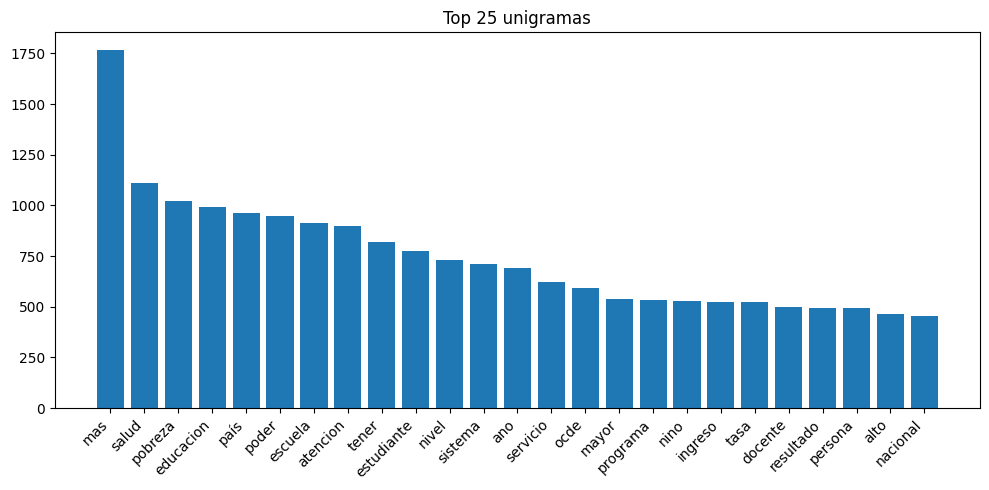

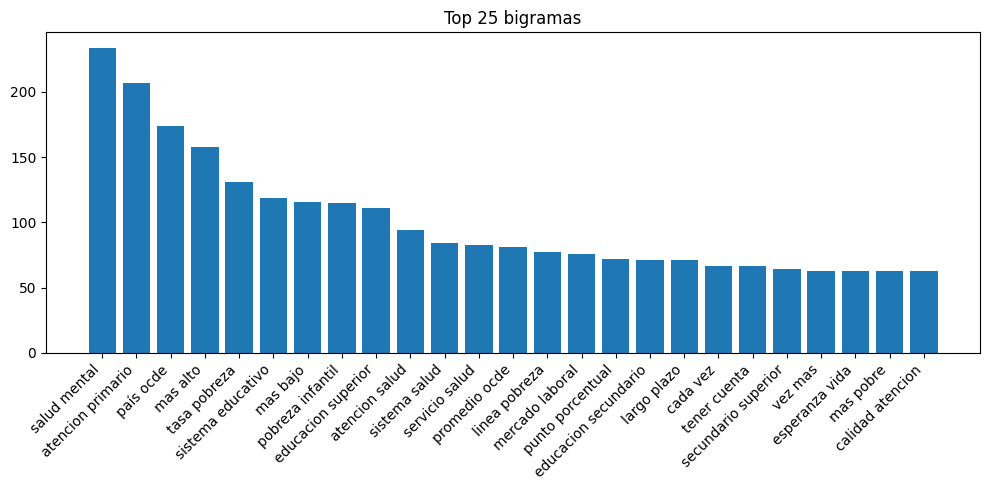

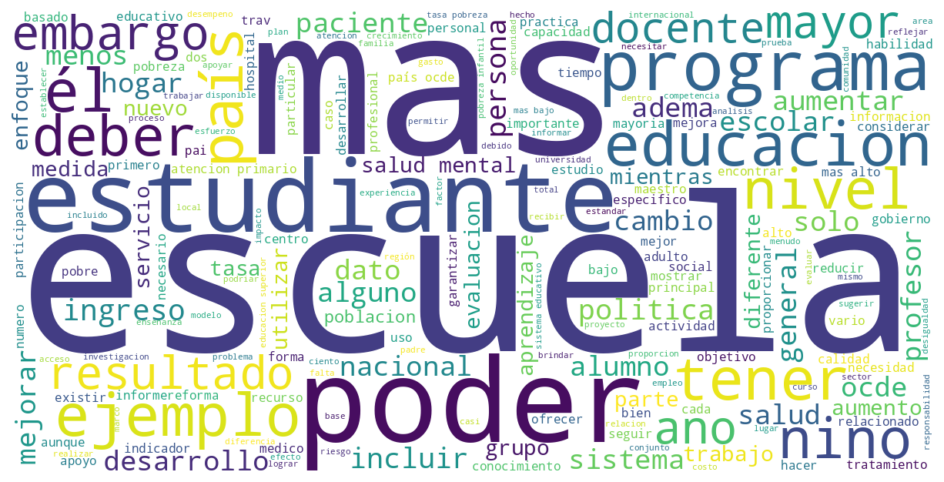

In [13]:
separador("SECCIÓN II. Limpieza, preprocesamiento y exploratorio")
extra_sw = None
cleaned, tokens_list = preprocess_series(df[col_texto], extra_stopwords=extra_sw)
df2 = df.copy(); df2["texto_limpio"] = cleaned
display(df2[["texto_limpio"]].head(3))

topn = 25
uni = most_common_terms(tokens_list, topn=topn)
bi  = most_common_bigrams(tokens_list, topn=topn)
print("[TOP UNIGRAMAS]", uni[:10])
print("[TOP BIGRAMAS]", bi[:10])

# Barras y WordCloud
def plot_bars(pairs, title, filename=None):
    labels = [p[0] for p in pairs]
    vals = [p[1] for p in pairs]
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(vals)), vals)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.title(title); plt.tight_layout()
    if filename: plt.savefig(filename, dpi=150, bbox_inches="tight")
    plt.show()

plot_bars(uni, f"Top {topn} unigramas", "top_unigramas.png")
plot_bars(bi,  f"Top {topn} bigramas",   "top_bigramas.png")

text_wc = " ".join([" ".join(toks) for toks in tokens_list if toks])
wc = WordCloud(width=1200, height=600, background_color="white").generate(text_wc)
plt.figure(figsize=(12,6)); plt.imshow(wc, interpolation="bilinear"); plt.axis("off")
plt.savefig("wordcloud.png", dpi=150, bbox_inches="tight"); plt.show()


## III) TF‑IDF y Modelado (LogReg, LinearSVC, RF+SVD) + Persistencia con joblib



################################################################################
SECCIÓN III. TF-IDF y Modelado (LogReg, LinearSVC, RF+SVD)
################################################################################

SECCIÓN III. TF-IDF y Modelado (LogReg, LinearSVC, RF+SVD)
[INFO] TF-IDF shape: (2424, 20000)

[Logistic Regression]
               precision    recall  f1-score   support

           1       0.96      0.95      0.96       101
           3       0.97      0.97      0.97       179
           4       0.98      0.98      0.98       205

    accuracy                           0.97       485
   macro avg       0.97      0.97      0.97       485
weighted avg       0.97      0.97      0.97       485



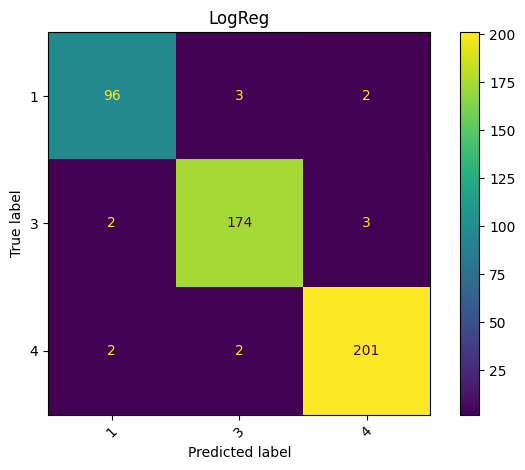


[LinearSVC]
               precision    recall  f1-score   support

           1       0.96      0.95      0.96       101
           3       0.97      0.98      0.98       179
           4       0.99      0.98      0.98       205

    accuracy                           0.98       485
   macro avg       0.97      0.97      0.97       485
weighted avg       0.98      0.98      0.98       485



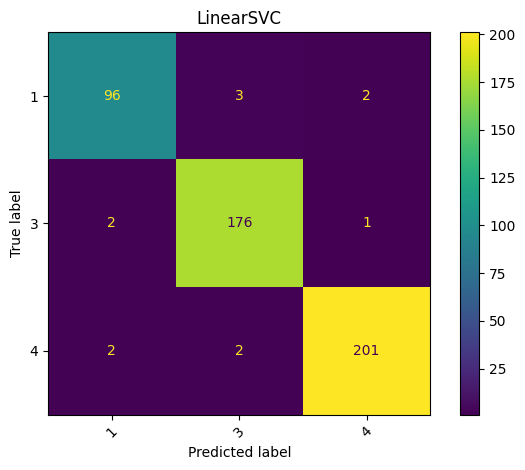


[RandomForest + SVD]
               precision    recall  f1-score   support

           1       0.95      0.87      0.91       101
           3       0.92      0.98      0.95       179
           4       0.98      0.96      0.97       205

    accuracy                           0.95       485
   macro avg       0.95      0.94      0.94       485
weighted avg       0.95      0.95      0.95       485



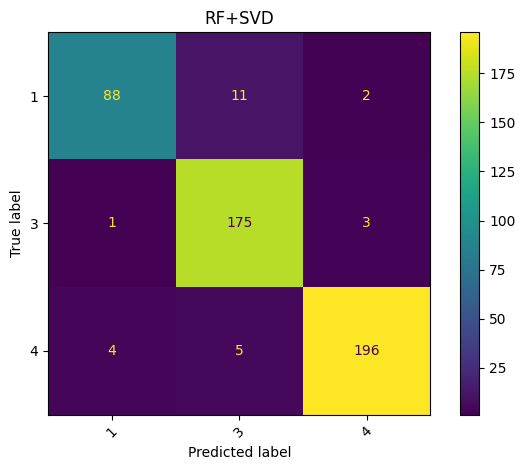

,modelo,accuracy,f1_weighted,f1_macro
0,LinearSVC,0.975258,0.975240,0.971962
1,LogReg,0.971134,0.971110,0.968464
2,RandomForest_SVD,0.946392,0.946153,0.939560


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[OK] Artefactos guardados en carpeta ./artefactos


In [8]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

separador("SECCIÓN III. TF-IDF y Modelado (LogReg, LinearSVC, RF+SVD)")

max_feat = 20000
vect = TfidfVectorizer(max_features=max_feat, ngram_range=(1,2), sublinear_tf=True)
X = vect.fit_transform(df2["texto_limpio"].astype(str))
print(f"[INFO] TF-IDF shape: {X.shape}")

if col_label:
    y = df[col_label].astype(str)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Modelo 1: Logistic Regression
    lr = LogisticRegression(max_iter=2000, class_weight="balanced")
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    print("\n[Logistic Regression]\n", classification_report(y_test, y_pred_lr, zero_division=0))
    cm = confusion_matrix(y_test, y_pred_lr, labels=np.unique(y_test))
    ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test)).plot(xticks_rotation=45); plt.title("LogReg"); plt.tight_layout(); plt.show()

    # Modelo 2: LinearSVC
    svc = LinearSVC(C=1.0)
    svc.fit(X_train, y_train)
    y_pred_svc = svc.predict(X_test)
    print("\n[LinearSVC]\n", classification_report(y_test, y_pred_svc, zero_division=0))
    cm = confusion_matrix(y_test, y_pred_svc, labels=np.unique(y_test))
    ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test)).plot(xticks_rotation=45); plt.title("LinearSVC"); plt.tight_layout(); plt.show()

    # Modelo 3: RandomForest + SVD
    n_comp = 300
    svd = TruncatedSVD(n_components=n_comp, random_state=42)
    X_train_svd = svd.fit_transform(X_train); X_test_svd = svd.transform(X_test)

    rf = RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_leaf=1,
        class_weight="balanced_subsample", n_jobs=-1, random_state=42
    )
    rf.fit(X_train_svd, y_train)
    y_pred_rf = rf.predict(X_test_svd)
    print("\n[RandomForest + SVD]\n", classification_report(y_test, y_pred_rf, zero_division=0))
    cm = confusion_matrix(y_test, y_pred_rf, labels=np.unique(y_test))
    ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test)).plot(xticks_rotation=45); plt.title("RF+SVD"); plt.tight_layout(); plt.show()

    # Resumen comparativo (SOLO BOW)
    resumen = pd.DataFrame([
        {"modelo":"LogReg","accuracy":accuracy_score(y_test, y_pred_lr),"f1_weighted":f1_score(y_test, y_pred_lr, average="weighted"),"f1_macro":f1_score(y_test, y_pred_lr, average="macro")},
        {"modelo":"LinearSVC","accuracy":accuracy_score(y_test, y_pred_svc),"f1_weighted":f1_score(y_test, y_pred_svc, average="weighted"),"f1_macro":f1_score(y_test, y_pred_svc, average="macro")},
        {"modelo":"RandomForest_SVD","accuracy":accuracy_score(y_test, y_pred_rf),"f1_weighted":f1_score(y_test, y_pred_rf, average="weighted"),"f1_macro":f1_score(y_test, y_pred_rf, average="macro")},
    ]).sort_values("f1_weighted", ascending=False).reset_index(drop=True)
    display(resumen)
    resumen.to_csv("resumen_modelos.csv", index=False, encoding="utf-8")
    download_file_if_colab("resumen_modelos.csv")

    # ===== Persistencia con joblib (vectorizador + MEJOR MODELO de los tres) =====
    os.makedirs("artefactos", exist_ok=True)
    dump(vect, "artefactos/vectorizador_tfidf.joblib")

    best = resumen.iloc[0]["modelo"]
    if best == "RandomForest_SVD":
        dump(svd, "artefactos/svd_300.joblib")
        dump(rf,  "artefactos/mejor_modelo.joblib")
    elif best == "LogReg":
        dump(lr,  "artefactos/mejor_modelo.joblib")
    else:
        dump(svc, "artefactos/mejor_modelo.joblib")
    print("[OK] Artefactos guardados en carpeta ./artefactos")


### (Opcional) Modelo 4 — Embeddings + LR (NO participa en selección)


[Embeddings] Cargando modelo 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2' en dispositivo: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[Embeddings] Codificando (batch=32)…


Batches:   0%|          | 0/61 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]


[Embeddings + LR] (NO participa en selección)
               precision    recall  f1-score   support

           1       0.93      0.96      0.95       101
           3       0.97      0.97      0.97       179
           4       0.99      0.98      0.99       205

    accuracy                           0.97       485
   macro avg       0.96      0.97      0.97       485
weighted avg       0.97      0.97      0.97       485



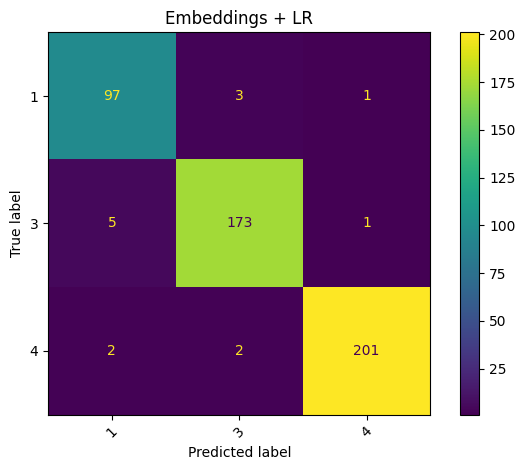

[INFO] Guardado 'resumen_wordemb.csv' (no se descarga automáticamente).


In [9]:
try:
    if not ENABLE_EMBEDDINGS or not col_label:
        print("[Embeddings] Deshabilitado o no hay etiqueta. Omitiendo…")
    else:
        try:
            from sentence_transformers import SentenceTransformer
        except Exception:
            SentenceTransformer = None

        if SentenceTransformer is None:
            print("[Embeddings] 'sentence-transformers' no está disponible. Omitido.")
        else:
            from sklearn.linear_model import LogisticRegression as _LR_EMB
            device = "cuda" if torch.cuda.is_available() else "cpu"
            print(f"[Embeddings] Cargando modelo '{EMB_MODEL}' en dispositivo: {device}")
            st_model = SentenceTransformer(EMB_MODEL, device=device)
            st_model.max_seq_length = EMB_MAX_LEN

            # Textos alineados
            X_train_texts = df2.loc[y_train.index, "texto_limpio"].astype(str).tolist()
            X_test_texts  = df2.loc[y_test.index,  "texto_limpio"].astype(str).tolist()

            if len(X_train_texts) > EMB_MAX_DOCS:
                import numpy as np
                rng = np.random.default_rng(42)
                idx = rng.choice(len(X_train_texts), EMB_MAX_DOCS, replace=False)
                X_train_texts = [X_train_texts[i] for i in idx]
                y_train_sample = y_train.iloc[idx]
                print(f"[Embeddings] Train reducido a {len(X_train_texts)} docs (muestra).")
            else:
                y_train_sample = y_train

            batch_sz = 64 if device == "cuda" else 32
            print(f"[Embeddings] Codificando (batch={batch_sz})…")
            X_train_emb = st_model.encode(X_train_texts, batch_size=batch_sz, convert_to_numpy=True,
                                          normalize_embeddings=True, show_progress_bar=True)
            X_test_emb  = st_model.encode(X_test_texts,  batch_size=batch_sz, convert_to_numpy=True,
                                          normalize_embeddings=True, show_progress_bar=True)

            lr_emb = _LR_EMB(max_iter=2000, class_weight="balanced")
            lr_emb.fit(X_train_emb, y_train_sample)
            y_pred_emb = lr_emb.predict(X_test_emb)

            print("\n[Embeddings + LR] (NO participa en selección)\n",
                  classification_report(y_test, y_pred_emb, zero_division=0))
            cm = confusion_matrix(y_test, y_pred_emb, labels=np.unique(y_test))
            ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test)).plot(xticks_rotation=45)
            plt.title("Embeddings + LR"); plt.tight_layout(); plt.show()

            pd.DataFrame([{
                "modelo":"Embeddings_LR",
                "accuracy":accuracy_score(y_test, y_pred_emb),
                "f1_weighted":f1_score(y_test, y_pred_emb, average="weighted"),
                "f1_macro":f1_score(y_test, y_pred_emb, average="macro")
            }]).to_csv("resumen_wordemb.csv", index=False, encoding="utf-8")
            print("[INFO] Guardado 'resumen_wordemb.csv' (no se descarga automáticamente).")
except Exception as e:
    print(f"[Embeddings] Omitido por error: {e}")


## IV) Etiquetado de archivo de PRUEBA (con el MEJOR modelo BOW)


In [10]:
separador("SECCIÓN IV. Etiquetado de archivo de PRUEBA")

if col_label:
    test_path = ensure_expected_file(TEST_FILE, "Archivo de PRUEBA para predecir etiquetas con el mejor modelo.")
    if test_path:
        df_test = read_excel_biggest_sheet(test_path)
        col_txt_test = col_texto if col_texto in df_test.columns else (
            df_test.select_dtypes(include=["object"]).columns.tolist()[0] if len(df_test.select_dtypes(include=["object"]).columns) else None
        )
        if col_txt_test is None:
            print("[ADVERTENCIA] No se encontró columna de texto en el archivo de prueba.")
        else:
            cleaned_test, _ = preprocess_series(df_test[col_txt_test])
            # Cargar mejor modelo desde memoria de esta sesión (ya entrenado arriba)
            best = pd.read_csv("resumen_modelos.csv").iloc[0]["modelo"]
            if best == "RandomForest_SVD":
                from sklearn.decomposition import TruncatedSVD
                from sklearn.ensemble import RandomForestClassifier
                svd_full = TruncatedSVD(n_components=300, random_state=42)
                X_all_svd = svd_full.fit_transform(vect.transform(df2['texto_limpio'].astype(str)))
                rf_full = RandomForestClassifier(
                    n_estimators=400, max_depth=None, min_samples_leaf=1,
                    class_weight="balanced_subsample", n_jobs=-1, random_state=42
                )
                rf_full.fit(X_all_svd, y)
                X_test_full_svd = svd_full.transform(vect.transform(cleaned_test.astype(str)))
                yhat = rf_full.predict(X_test_full_svd)
            elif best == "LogReg":
                from sklearn.linear_model import LogisticRegression
                lr_full = LogisticRegression(max_iter=2000, class_weight="balanced")
                lr_full.fit(vect.transform(df2['texto_limpio'].astype(str)), y)
                yhat = lr_full.predict(vect.transform(cleaned_test.astype(str)))
            else:
                from sklearn.svm import LinearSVC
                svc_full = LinearSVC(C=1.0)
                svc_full.fit(vect.transform(df2['texto_limpio'].astype(str)), y)
                yhat = svc_full.predict(vect.transform(cleaned_test.astype(str)))

            df_test["prediccion_modelo"] = yhat
            out_xlsx = "Datos_de_prueba_con_prediccion.xlsx"
            df_test.to_excel(out_xlsx, index=False)
            print(f"[OK] Guardado: {out_xlsx}")
            download_file_if_colab(out_xlsx)
else:
    # Sin etiqueta → Clustering básico
    vect2 = TfidfVectorizer(max_features=20000, ngram_range=(1,2), sublinear_tf=True)
    X2 = vect2.fit_transform(df2["texto_limpio"].tolist())
    km = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X2.toarray())
    print("[INFO] Clustering completado.")



################################################################################
SECCIÓN IV. Etiquetado de archivo de PRUEBA
################################################################################

SECCIÓN IV. Etiquetado de archivo de PRUEBA
[NECESARIO] Falta el archivo requerido: 'Datos de prueba_proyecto.xlsx' → Archivo de PRUEBA para predecir etiquetas con el mejor modelo.
[ACCION] Por favor, sube ahora el archivo EXACTO llamado 'Datos de prueba_proyecto.xlsx'.


Saving Datos de prueba_proyecto.xlsx to Datos de prueba_proyecto.xlsx
[OK] Subido: Datos de prueba_proyecto.xlsx
[INFO] Hojas encontradas: ['Sheet1']
[INFO] Hoja seleccionada: 'Sheet1' (152 filas)
[OK] Guardado: Datos_de_prueba_con_prediccion.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>